In [4]:
import pandas as pd

# Load the cleaned Netflix data
df = pd.read_csv("/Users/cem/Desktop/netflix_titles_cleaned.csv")

# Show the first few rows
df.head()

# Filter the dataset for release_year >= 2010
df_subset = df[df['release_year'] >= 2010].copy()

df_subset.reset_index(drop=True, inplace=True)
df_subset['release_year'] = pd.to_datetime(df_subset['release_year'], format='%Y')

df_subset.set_index('release_year', inplace=True)
df_subset.head()


,show_id,type,title,director,cast,country,date_added,rating,duration,listed_in,description
release_year,,,,,,,,,,,
2020-01-01,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
2021-01-01,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2021-01-01,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
2021-01-01,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
2021-01-01,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


To ensure relevance and consistency, I created a subset of the Netflix dataset containing only titles released from 2010 onwards. This period marks the significant expansion of Netflix’s global streaming service and the addition of a large number of titles.

Earlier years contained sparse entries and could bias trends due to low sample size. I also removed any future-dated or forecasted data (none were found in this case), reset the index, and set the release_year column as a proper datetime index for time-series analysis.

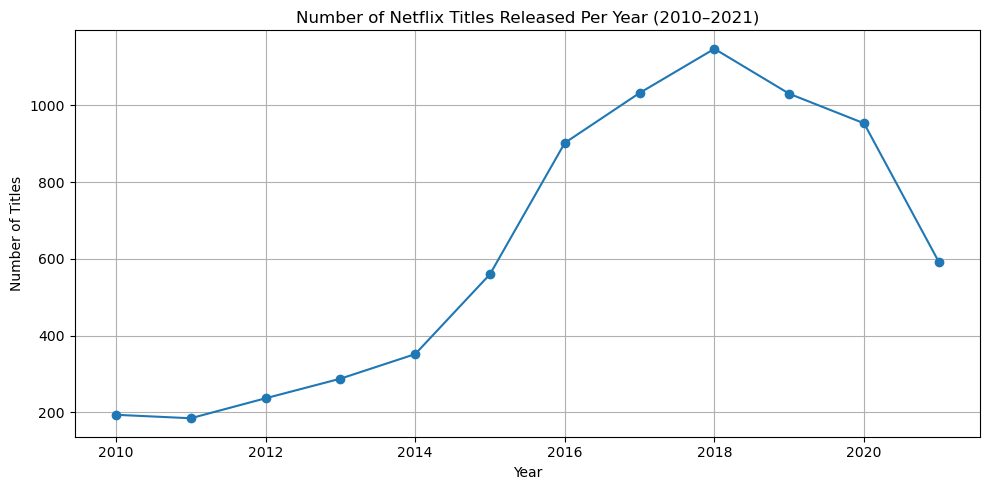

In [6]:
import matplotlib.pyplot as plt

# Count the number of titles released per year
title_counts = df_subset.resample('YE').count()['title']

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(title_counts.index.year, title_counts.values, marker='o', linestyle='-')
plt.title('Number of Netflix Titles Released Per Year (2010–2021)')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.grid(True)
plt.tight_layout()
plt.show()


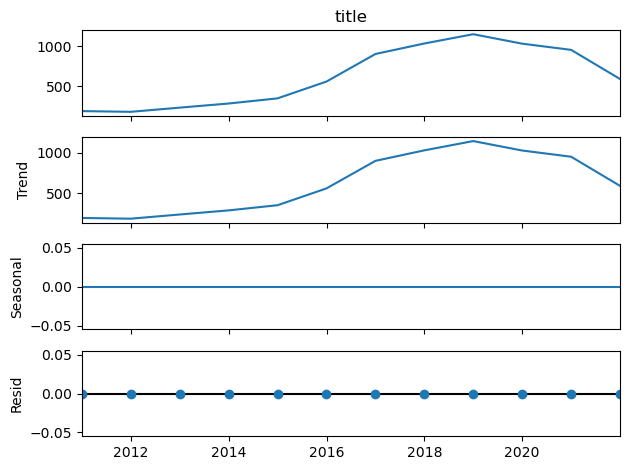

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Make sure your index is datetime and sorted
df_subset = df_subset.sort_index()

# Resample to yearly counts
title_counts = df_subset.resample('YE').count()['title']

# Decompose (using additive model)
decomposition = seasonal_decompose(title_counts, model='additive', period=1)
decomposition.plot()
plt.tight_layout()
plt.show()

### Time Series Decomposition Analysis

From the decomposition plot, we can observe the following:

    - Trend: There is a clear upward trend in the number of Netflix titles added each year from around 2012 to 2018, peaking in 2019. After that, there’s a decline starting around 2020, possibly due to industry-wide disruptions (e.g., COVID-19 pandemic).

    - Seasonality: The seasonal component is completely flat, indicating no strong yearly seasonality in the data. This makes sense since Netflix releases don’t follow a strict seasonal pattern like retail or agriculture data.

    - Residuals: The residuals (or noise) are essentially flat, meaning there’s little unexplained variability left after removing the trend. This suggests that the trend alone explains most of the changes in the time series.

In [11]:
from statsmodels.tsa.stattools import adfuller

# Use the yearly count of titles (numeric)
title_counts = df_subset.resample('YE').count()['title']

# Run ADF test on the numeric time series
result = adfuller(title_counts)

print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -2.410837575787156
p-value: 0.13870091783138155
Critical Value (1%): -4.9386902332361515
Critical Value (5%): -3.477582857142857
Critical Value (10%): -2.8438679591836733


### Dickey-Fuller Test for Stationarity

Null Hypothesis (H₀): The time series is not stationary (contains a unit root).
Alternative Hypothesis (H₁): The time series is stationary.
Test Results:

    - ADF Statistic: -2.41

    - p-value: 0.1387

    - Critical Values:

        - 1%: -4.94

        - 5%: -3.48

        - 10%: -2.84

Interpretation:

Since the p-value (0.1387) is greater than 0.05, we fail to reject the null hypothesis.
This means the time series is not stationary. It exhibits a trend or other non-stationary behavior.

To continue with time-series modeling (e.g., ARIMA), we should apply a transformation, such as first-order differencing, to make the series stationary.

In [14]:
# Step 1: Resample the data by year and count the number of titles
title_counts = df_subset.resample('YE').count()['title']

# Step 2: First-order differencing
df_diff1 = title_counts.diff().dropna()

# Step 3: Second-order differencing
df_diff2 = df_diff1.diff().dropna()

# Step 4: Dickey-Fuller test on second-order differenced data
from statsmodels.tsa.stattools import adfuller

result_diff2 = adfuller(df_diff2)
print(f"ADF Statistic: {result_diff2[0]}")
print(f"p-value: {result_diff2[1]}")
for key, value in result_diff2[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Statistic: -2.6369291180687493
p-value: 0.08560240528418234
Critical Value (1%): -4.473135048010974
Critical Value (5%): -3.28988060356653
Critical Value (10%): -2.7723823456790124


### Dickey-Fuller Test – Second Differencing (Interpretation)

After applying a second-order differencing to the annual count of Netflix titles, we conducted the Augmented Dickey-Fuller (ADF) test to assess stationarity. The test returned the following:

    ADF Statistic: -2.6369

    p-value: 0.0856

    Critical Values:

        1%: -4.4731

        5%: -3.2899

        10%: -2.7724

Our null hypothesis assumes the time series is non-stationary. Since the p-value is above 0.05 and the ADF statistic is not lower than the 5% or 10% critical values, we fail to reject the null hypothesis. Therefore, the series still shows signs of non-stationarity, though it is trending closer toward stationarity.

In [15]:
from statsmodels.tsa.stattools import adfuller

# Third round of differencing
df_diff3 = df_diff2.diff().dropna()

# Run the Dickey-Fuller test
result = adfuller(df_diff3)

# Print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Statistic: -5.946229390825846
p-value: 2.2009222434306568e-07
Critical Value (1%): -4.6651863281249994
Critical Value (5%): -3.3671868750000002
Critical Value (10%): -2.802960625


<Figure size 1000x400 with 0 Axes>

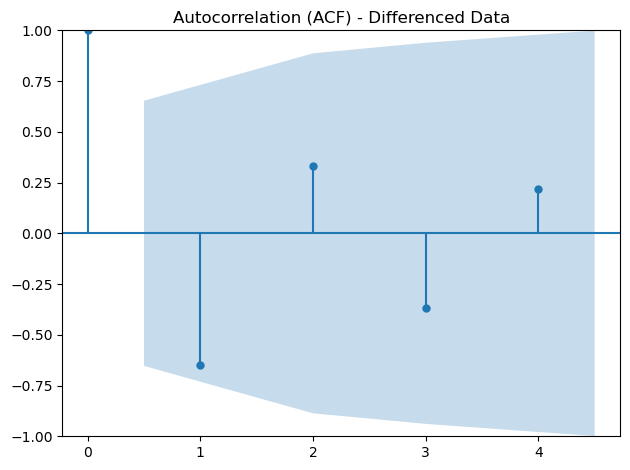

<Figure size 1000x400 with 0 Axes>

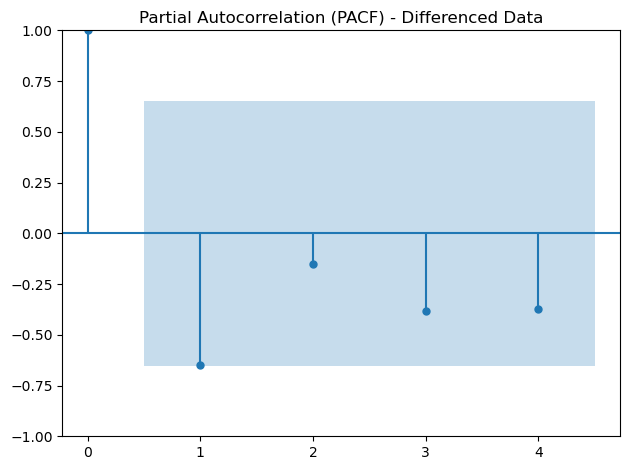

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Calculate maximum safe lag (usually less than n/2)
max_lags = min(10, len(df_diff3) // 2)

# Plot ACF
plt.figure(figsize=(10, 4))
plot_acf(df_diff3, lags=max_lags)
plt.title("Autocorrelation (ACF) - Differenced Data")
plt.tight_layout()
plt.show()

# Plot PACF
plt.figure(figsize=(10, 4))
plot_pacf(df_diff3, lags=max_lags, method='ywm')
plt.title("Partial Autocorrelation (PACF) - Differenced Data")
plt.tight_layout()
plt.show()
